In [7]:
'''Packages'''
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
import random
import copy


In [5]:
'''Prepare data'''

bioresponce = pd.read_csv('F:/Documents/ITMO/1курс/Machine_Learning_2022/Lab1/Task_1/bioresponse.csv', header=0, sep=',')

train_data, test_data,  = train_test_split(bioresponce, test_size = 0.25, random_state = 1)
X_train =  train_data.iloc[:,1:] 
Y_train =  train_data.iloc[:,0]
X_test =    test_data.iloc[:,1:]                                                                       
Y_test =  test_data.iloc[:,0]

#Reshape it to make it applicable for the code from the seminar
Y_train = np.array(Y_train)
Y_train.shape
Y_train = Y_train.reshape(1,len(Y_train))

Y_test = np.array(Y_test)
Y_test.shape
Y_test = Y_test.reshape(1,len(Y_test))

X_train = X_train.T
X_test = X_test.T

In [4]:
'''Main functions'''
# sigmoid
def sigmoid(z):
    #The bounds are added in order to overcome the problem when sigmoid returns 1
    s = 1./(1.+np.exp(-z))
    s = np.minimum(s, 0.9999)  # Set upper bound
    s = np.maximum(s, 0.0001)  # Set lower bound
    return s

def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0.
    return w, b

dim = X_train.shape[0]
w, b = initialize_with_zeros(dim)


# propagate
def propagate(w, b, X, Y):

    m = X.shape[1]
    #print('number of objects = ',len(X))
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                              # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost



def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

    costs = []
    
    for i in range(num_iterations):
                
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

# predict
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction

# model
#I added the optional optimizer
def model(X_train, Y_train, X_test, Y_test, optimizer, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimizer(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [16]:
'''1st point - applying logistic regression'''
result1 = model(X_train, Y_train, X_test, Y_test,optimizer = optimize,num_iterations = 2000, learning_rate = 0.05, print_cost = False)



train accuracy: 82.29648062566655 %
test accuracy: 77.61194029850746 %


In [9]:
'''Stochastic Gradient optimizer'''
def optimize_SGD(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    for i in range(num_iterations):
                
        # Cost and gradient calculation 
        # Add random (random choice of number of selected observations and random subset of them)
        num = random.randint(200,len(X.T))

        df_before = copy.deepcopy(X)
        df_before.loc[X.shape[0]] = Y.tolist()[0]

        df_after = df_before.sample(n=num,axis='columns')
        X_sub = df_after[0:len(df_after)-1]
        Y_sub = df_after.iloc[-1].tolist()
        Y_sub = np.array(Y_sub).reshape(1,len(Y_sub))

        grads, cost = propagate(w,b,X_sub,Y_sub)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        costs.append(cost)
            
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [10]:
'''2nd point - applying logistic regression with stochastic gradient optimizer'''

result2 = model(X_train, Y_train, X_test, Y_test,optimizer = optimize_SGD, num_iterations = 2000, learning_rate = 0.05, print_cost = False)


train accuracy: 82.36757909704941 %
test accuracy: 77.39872068230277 %


train accuracy: 82.29648062566655 %
test accuracy: 77.61194029850746 %
train accuracy: 84.18059011731248 %
test accuracy: 76.75906183368869 %
train accuracy: 85.56701030927834 %
test accuracy: 76.11940298507463 %
train accuracy: 82.61642374688944 %
test accuracy: 73.98720682302772 %
train accuracy: 80.48346960540349 %
test accuracy: 71.53518123667376 %


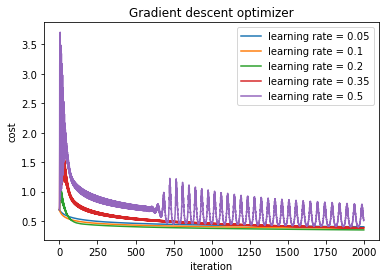

0.05
train accuracy: 82.43867756843228 %
test accuracy: 77.50533049040511 %
0.1
train accuracy: 84.39388553146108 %
test accuracy: 77.29211087420043 %
0.2
train accuracy: 85.24706718805545 %
test accuracy: 76.22601279317698 %
0.35
train accuracy: 84.25168858869534 %
test accuracy: 74.30703624733476 %
0.5
train accuracy: 84.82047635975826 %
test accuracy: 74.94669509594883 %


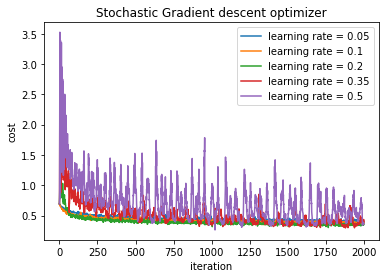

In [20]:
'''3rd point - learning curve plot'''
costs = pd.DataFrame()

for l_rate in [0.05,0.1,0.2,0.35,0.5]:
    costs[str(l_rate)] = model(X_train, Y_train, X_test, Y_test,optimizer = optimize, num_iterations = 2000, learning_rate = l_rate, print_cost = False)['costs']

for l_rate in [0.05,0.1,0.2,0.35,0.5]:
    plt.plot(costs[str(l_rate)], label = "learning rate = " + str(l_rate))
plt.legend()
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("Gradient descent optimizer")
plt.show()



costs_SGD = pd.DataFrame()

for l_rate in [0.05,0.1,0.2,0.35,0.5]:
    print(str(l_rate))
    costs_SGD[str(l_rate)] = model(X_train, Y_train, X_test, Y_test,optimizer = optimize_SGD, num_iterations = 2000, learning_rate = l_rate, print_cost = False)['costs']

for l_rate in [0.05,0.1,0.2,0.35,0.5]:
    plt.plot(costs_SGD[str(l_rate)], label = "learning rate = " + str(l_rate))
plt.legend()
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("Stochastic Gradient descent optimizer")
plt.show()

In [11]:
'''4th point - ADAM optimizer'''


def optimize_ADAM(w, b, X, Y, num_iterations, learning_rate, print_cost = False,eps = 0.0001,B_1 = 0.9, B_2 = 0.999):
    
    costs = []
    S_t = np.array([0]*len(w)).reshape(len(w),1)
    S_t_b = 0
    V_t = np.array([0]*len(w)).reshape(len(w),1)
    V_t_b = 0
    for i in range(num_iterations):

        grads, cost = propagate(w,b,X,Y)
        
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]


        V_t1 = B_1*V_t + (1-B_1)*(dw)
        S_t1 = B_2*S_t + (1-B_2)*(dw**2)

        V_t_b1 = B_1*V_t_b + (1-B_1)*(db)
        S_t_b1 = B_2*S_t_b + (1-B_2)*(db**2)
        V_t = V_t1
        S_t = S_t1
        S_t_b = S_t_b1
        V_t_b = V_t_b1

        # update rule
        w -=learning_rate*V_t1/(S_t1**(1/2) + eps)
        b -=learning_rate*V_t_b1/(np.sqrt(S_t_b1) + eps)
        
        # Record the costs
        costs.append(cost)
        

    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [19]:
#result
result3 = model(X_train, Y_train, X_test, Y_test,optimizer = optimize_ADAM, num_iterations = 2000, learning_rate = 0.05, print_cost = False)

train accuracy: 95.84073942410238 %
test accuracy: 73.2409381663113 %


In [18]:
print("For all models learning rate = 0.05, 2000 iterations")
print("GD test accuracy: {} %".format(100 - np.mean(np.abs(result1["Y_prediction_test"] - Y_test)) * 100))
print("SGD test accuracy: {} %".format(100 - np.mean(np.abs(result2["Y_prediction_test"] - Y_test)) * 100))
print("ADAM test accuracy: {} %".format(100 - np.mean(np.abs(result3["Y_prediction_test"] - Y_test)) * 100))

For all models learning rate = 0.05, 2000 iterations
GD test accuracy: 77.61194029850746 %
SGD test accuracy: 77.39872068230277 %
ADAM test accuracy: 73.2409381663113 %
